# Let's call all libraries and define city and road variables

In [1]:
import networkx as nx 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg 
import json 
from itertools import combinations 
import random 
from time import time

# VERTICES are list of all cities
with open('cities.txt') as f:
    VERTICES = [i.rstrip() for i in f] # stripping "\n" from end of lines and seperating all lines
    
# EDGES are roads connecting 2 cities (City A,City B,Distance,Color)
with open('roads.txt') as f:
    next(f) # skipping header
    EDGES = [tuple(i.strip().split(',')) for i in f] # stripping "\n" and making other , seperated terms a tuple
    
# TICKETS are given by the game. The goal is to connect those 2 cities, 3rd input is the point you get from completing
# (City A,City B,Points)
with open('tickets.txt') as f:
    next(f) # skipping header
    TICKETS = [tuple(i.strip().split(',')) for i in f] # stripping "\n" and making other , seperated terms a tuple

# City_locations are dictionary of all cities as (cityname:[posx, posy])
with open('city_locations.json') as f:
    CITY_LOCATIONS = json.load(f)

# Build bidirectional weighted graph from the VERTICES and EDGES

In [2]:
G = nx.MultiGraph()
G.add_nodes_from(VERTICES) #add vertices

for edge in EDGES:
    G.add_edge(edge[0], edge[1], weight = int(edge[2]), colour = edge[3])

# Steiner tree tries to find minimum sum of weights to connect given nods

In [3]:
# Note: Finding optimal Steiner Tree is an NP problem and the function nx.steiner_tree() just approximates 
#the best solution
# Had "no attribute" problems for this function. It is copied from the documentation, made some slight changes and 
# removed unnecessary functions:

from networkx.utils import pairwise 

def steiner_tree(G, terminal_nodes, weight="weight"):
    method = "mehlhorn"
        
    try:
        algo = _mehlhorn_steiner_tree
    except KeyError as e:
        raise ValueError(f"{method} is not a valid choice for an algorithm.") from e

    edges = algo(G, terminal_nodes, weight)
    # For multigraph we should add the minimal weight edge keys
    if G.is_multigraph():
        edges = (
            (u, v, min(G[u][v], key=lambda k: G[u][v][k][weight])) for u, v in edges
        )
    T = G.edge_subgraph(edges)
    return T

def _mehlhorn_steiner_tree(G, terminal_nodes, weight):
    paths = nx.multi_source_dijkstra_path(G, terminal_nodes)

    d_1 = {}
    s = {}
    for v in G.nodes():
        s[v] = paths[v][0]
        d_1[(v, s[v])] = len(paths[v]) - 1

    # G1-G4 names match those from the Mehlhorn 1988 paper.
    G_1_prime = nx.Graph()
    for u, v, data in G.edges(data=True):
        su, sv = s[u], s[v]
        weight_here = d_1[(u, su)] + data.get(weight, 1) + d_1[(v, sv)]
        if not G_1_prime.has_edge(su, sv):
            G_1_prime.add_edge(su, sv, weight=weight_here)
        else:
            new_weight = min(weight_here, G_1_prime[su][sv]["weight"])
            G_1_prime.add_edge(su, sv, weight=new_weight)

    G_2 = nx.minimum_spanning_edges(G_1_prime, data=True)

    G_3 = nx.Graph()
    for u, v, d in G_2:
        path = nx.shortest_path(G, u, v, weight)
        for n1, n2 in pairwise(path):
            G_3.add_edge(n1, n2)

    G_3_mst = list(nx.minimum_spanning_edges(G_3, data=False))
    if G.is_multigraph():
        G_3_mst = (
            (u, v, min(G[u][v], key=lambda k: G[u][v][k][weight])) for u, v in G_3_mst
        )
    G_4 = G.edge_subgraph(G_3_mst).copy()
    _remove_nonterminal_leaves(G_4, terminal_nodes)
    return G_4.edges()

def _remove_nonterminal_leaves(G, terminals):
    terminals_set = set(terminals)
    for n in list(G.nodes):
        if n not in terminals_set and G.degree(n) == 1:
            G.remove_node(n)

# Connect cities and include tickets:

In [4]:
# This function connects giving vertices with minimum weighted edges
def connect_cities(list_cities):
    edges_to_connect = _mehlhorn_steiner_tree(G, list_cities, weight = "weight")
    G2 =steiner_tree(G, list_cities) # find the shortest path connecting all cities in list_cities
    weight = int(G2.size(weight="weight")) # calculate it's weight
    
    return weight,G2

# To calculate train cost and points of a collection of path, we can select some indexes
# from 0 to 29 (len(TICKETS)=30). Then we're gonna calculate the weight, path and point.
# (not including longest path point since it's single player)
def calculate_point(indexes):
    city_lst = [TICKETS[i][j] for i in indexes for j in range(2)] # add city1 and city2   
    weight, G2 = connect_cities(city_lst)
    point_ticket = 0
    point_edge = 0
    for i in indexes:
        add = int(TICKETS[i][2]) # adding ticket points
        point_ticket += add
        
    # get specific weight of each edges used to calculate single road points
    EDGES_DICT = {(city1,city2):int(weight) for city1,city2,weight,color in EDGES}
    
    # adding weight conversion for edge points. (3 weight road is 4 point etc)
    POINT_EDGE_DICT = {i:j for i,j in zip(range(1,7),[1,2,4,7,10,15])}
    for i,j in G2.edges():
        try: 
            edge_weight = EDGES_DICT[(i,j)]
        except KeyError:
            edge_weight = EDGES_DICT[(j,i)]
        finally:
            point_edge += POINT_EDGE_DICT[edge_weight]
    
    point = point_ticket + point_edge # it's enough to return point, this way is just
    # to be able to seperate ticket and edge points in the end
            
    return (point_ticket, point_edge), weight, G2
# point, weight, G2 = calculate_point([0, 1, 2, 3, 4, 6, 7, 8, 9, 12, 14, 23, 29])

# Calculate best routes

In [5]:
""" the startegy will be to try all combinations of indexes. 
On each try, if it's possible, we'll add a new term and check if the train cost w exceeds 45. 
If w <= 45, we'll add a new index and continue. 
If w >45, we'll ignore that term and increase biggest index by 1
With this way we'll visit all combinations of indexes that are not exceeding w
Note that order of the indexes doesn't make a difference
Here we just selected a starting index list [0,1,2,3] But actually it doesnt matter as long
as you start with smallest indexes and don't skip any number. 
[0,1] gives the same output, but [6,7] doesn't (because it'll never try 0,1,2,3,4,5)
"""

def test_all_combinations(index_comb_lst): 
    max_point = 0
    best_weight = 0
    best_path_graph = []
    best_idx = []
    n = len(TICKETS)
    
    while True:
        (p1, p2), w, G2 = calculate_point(index_comb_lst)
        p = p1+p2
        if p > max_point and w<=45: # update the best path when max_point is exceeded
                max_point = p
                best_weight = w # it's actually just the weight that corresponds to p
                best_path_graph = G2
                best_idx = index_comb_lst.copy()
                
        if w <= 45:
            found_bool = False
            for i in range(1,len(index_comb_lst)+1):
                if index_comb_lst[-i] < n-i: # if the last term can increase by 1 without index error
                    max = index_comb_lst[-i] + 1 # max term that can be increased by 1
#                     index_comb_lst.insert(-i,max) # insert it to the list to preserve order (doesnt work)
                    index_comb_lst.append(max)
                    index_comb_lst.sort()
                    found_bool = True # when bool is true, no need to remove a term
                    break  
            # this part actually gets rarely used and not so useful
            if not found_bool: # if bool is still false take out the minimum term       
                min = index_comb_lst[0]
                if len(index_comb_lst) == 1:
                    return max_point, best_weight, best_path_graph, best_idx
                index_comb_lst.remove(min)

        elif w > 45: # change the last term. If max of the array can increase by 1, increase it. 
    #Otherwise increase the 2nd max, or 3rd etc.
            add_bool = False
            for i in range(1,len(index_comb_lst)+1):
                if index_comb_lst[-i] < n-i: # if the last term can increase by 1 without index error
                    index_comb_lst[-i] += 1
                    add_bool = True # when bool is true, no need to remove a term
                    break   
                
            if not add_bool: # return when no term can increase 
                return max_point, best_weight, best_path_graph, best_idx
            
            
idx = [0, 1, 2, 3]
max_point, best_weight, best_path_graph, best_idx = test_all_combinations(idx)
print(f'max is reached at: {max_point} with {best_weight} trains with {best_idx}')

best_routes = [] # activate for the next code

max is reached at: 232 with 44 trains with [0, 1, 2, 3, 4, 6, 7, 8, 9, 12, 14, 23, 29]


In [6]:

"""Uncomment to use below. One for loop is around 1 sec. range(300) is around 300
ran this loop many times. best case I got was rearrangements of the same 275 points road
Also because of the shuffle usually this paths doesn't match given point/weight
need to figure it out"""
# acquired from the shuffle algorithm. gives 275 points
score_1 = [275, 45, [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 14, 16, 20, 23, 24, 27, 29], [('Montreal', 'New Orleans', '13'), ('San Francisco', 'Atlanta', '17'), ('Seattle', 'Los Angeles', '9'), ('Los Angeles', 'Chicago', '16'), ('Portland', 'Nashville', '17'), ('Portland', 'Phoenix', '11'), ('Los Angeles', 'New York', '21'), ('Calgary', 'Salt Lake City', '7'), ('Chicago', 'Santa Fe', '9'), ('New York', 'Atlanta', '6'), ('Winnipeg', 'Houston', '12'), ('Dallas', 'New York', '11'), ('Sault St. Marie', 'Oklahoma City', '9'), ('Boston', 'Miami', '12'), ('Vancouver', 'Montreal', '20'), ('Winnipeg', 'Little Rock', '11'), ('Montreal', 'Atlanta', '9'), ('Los Angeles', 'Miami', '20'), ('Helena', 'Los Angeles', '8'), ('Toronto', 'Miami', '10'), ('Vancouver', 'Santa Fe', '13'), ('Denver', 'Pittsburgh', '11'), ('Denver', 'El Paso', '4'), ('Calgary', 'Phoenix', '13'), ('Chicago', 'New Orleans', '7'), ('Duluth', 'Houston', '8'), ('Duluth', 'El Paso', '10'), ('Seattle', 'New York', '22'), ('Sault St. Marie', 'Nashville', '8'), ('Kansas City', 'Houston', '5')]]
score_2 = [0, 2, 3, 4, 5, 7, 8, 9, 12, 14, 19, 22, 23, 28, 29] #264 points 45 (normal TICKETS)

#lets find indexes of score_1 in normal TICKETS
score_1_cities = [score_1[3][i] for i in score_1[2]]
score_1_idx = [TICKETS.index(i) for i in score_1_cities] # goal idx list


# record = 270
# for i in range(300):
#     np.random.shuffle(TICKETS)
#     p, w, G2, idx = test_all_combinations([1,2,3,4])
#     if p >= record:
#         best_point = record
#         best_weight = w
#         best_idx = idx 
#         print([best_point, best_weight, best_idx])
#         # saving TICKETS is important as important as best_idx since it's shuffled
#         best_routes.extend([[best_point, best_weight, best_idx, TICKETS]])
        
#     if i in [50*k for k in range(100)]:
#         print(i) # track progression

# print(f'time elapsed: {time()-start}')

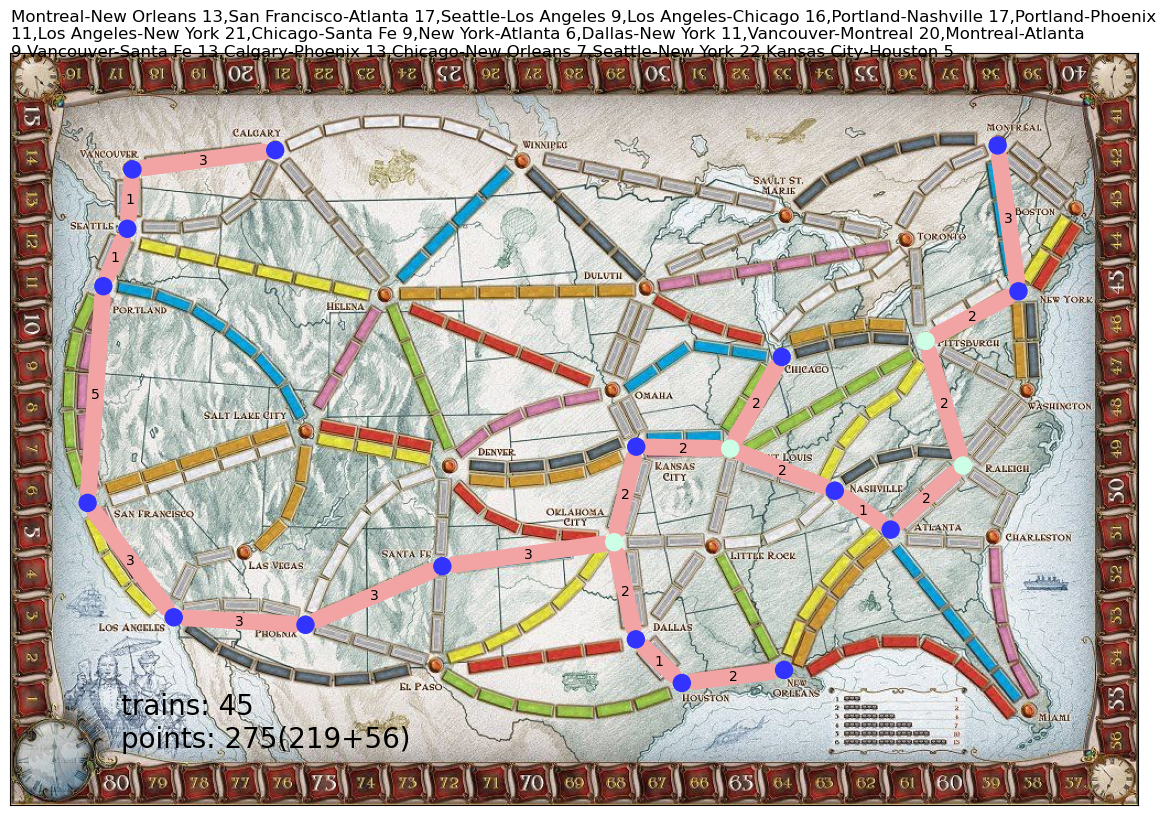

In [7]:
#plot the graph 
img=mpimg.imread('USA_map.jpg') # load the image
y, x, z= np.shape(img) # get the image size

# Here we make Atlanta:[a,b] into Atlanta:[a*x, (1-b)*y]
POS_REFLECTED = {VERTICES[i]:[CITY_LOCATIONS[VERTICES[i]][0]*x,
                              (1-CITY_LOCATIONS[VERTICES[i]][1])*y] for i in range(len(VERTICES))}

idx = score_1_idx # for the highest point path
# idx = best_idx # for plots with normal TICKETS arrangement - after using test_all_combinations()

# for plots with shuffled TICKETS arrangement
# idx,TICKETS = score_1[2:4] # see score_1 at the last cell for reference

best_route = [f'{TICKETS[i][0]}-{TICKETS[i][1]} {TICKETS[i][2]}' for i in idx]
best_route_text = ','.join(best_route)

(p1,p2), w, G2 = calculate_point(idx)
plt.subplots(figsize=(12, 9))
plt.imshow(img)
plt.text(100, 600, f"trains: {w}", size=20) # display number of trains used on the image
plt.text(100, 630, f"points: {p1+p2}({p1}+{p2})", size=20) # display total points on the image
plt.text(0, 0, best_route_text, size=12, wrap = True) # taken routes

# change colors of the nodes that are a ticket city (end or beginning)
ticket_nodes = {TICKETS[i][0] for i in idx} #add all ticket city nodes
ticket_nodes.update({TICKETS[i][1] for i in idx})

node_colors = ["#3333FF" if i in ticket_nodes # making ticket cities blue, other ones light blue
               else "#CCFFE5" for i in G2.nodes()]

nx.draw_networkx_nodes(G2, POS_REFLECTED, node_color=node_colors, 
                       node_size = 150)
# edges
nx.draw_networkx_edges(G2,POS_REFLECTED, width=12, edge_color = (0.95,0.64,0.64))

# edge labels
edge_labels = nx.get_edge_attributes(G2, "weight")
nx.draw_networkx_edge_labels(G2, POS_REFLECTED, edge_labels, rotate = False,
                            bbox = dict(alpha=0))
plt.tight_layout()
plt.show()


# for brute force testing (run all cells once before)

In [8]:
max_score = 100
for i in range(3,4): # for 3 tickets only, should be (12,18) or (13,18)
    idx_list = combinations(range(30),i) # itertools.combinations
    for j, k, l in idx_list: # idx_list is a generator. need to iterate it for each term
        (p1,p2), w, G2 = calculate_point([j,k,l]) # function takes list of indexes as input
        if p1+p2 > max_score and w <= 45: # new record and weight(trains) <= 45
            max_score = p1+p2
            weight = w
            best_idx = [j,k,l]
print(max_score, weight, best_idx)

139 45 [0, 5, 26]
